<a href="https://colab.research.google.com/github/drshahizan/Python_EDA/blob/main/assignment/ass4/bdm/KicapSambal/feature_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Feature Engineering**

**GROUP NAME: KICAP SAMBAL**

**TEAM MEMBERS:**
```
MOHD NOR BIN MOHIDIN (MCS231008)
NABILA HUSNA BINTI ROSLI (MCS231009)
NUR AZIMAH BINTI MOHD SALLEH (MCS231011)
ZUHAYR ARIF BIN ZAKARIA (MCS231002)
```

##**FLIGHT PRICE PREDICTION**

###**Dataset**
Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. There are 300261 datapoints and 11 features in the cleaned dataset.

###**Features**
The various features of the cleaned dataset are explained below:
1. `Airline`: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.
2. `Flight`: Flight stores information regarding the plane's flight code. It is a categorical feature.
3. Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.
4. `Departure Time`: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
5. `Stops`: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
6. `Arrival Time`: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
7. `Destination City`: City where the flight will land. It is a categorical feature having 6 unique cities.
8. `Class`: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
9. `Duration`: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
10. `Days Left`: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
11. `Price`: Target variable stores information of the ticket price.

# Importing the relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

# Import Data

Read data from two separate CSV files representing economy and business class flights, combines them into a single DataFrame (flight_df).

In [ ]:
# Load the data
economy_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/economy.csv')
business_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/business.csv')

# Combine the data
flight_df = pd.concat([economy_df, business_df], ignore_index=True)

flight_df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


# Exploratory Data Analysis

A new preprocessed DataFrame (`df_preprocessed`) is created. Columns are extracted or transformed from the original `flight_df` DataFrame. Notable preprocessing steps include formatting departure and arrival times, converting stops information, extracting flight duration in hours, and handling the price column.

Two new columns are added to the original flight_df DataFrame, namely '`departure_hour`' and '`departure_minute`'. These columns are obtained by extracting the hour and minute components from the 'dep_time' column, representing the departure time.

Two additional features are created: '`is_early_morning`' and '`is_late_night`'. These binary features indicate whether a flight departs in the early morning (between 4 AM and 8 AM) or late at night (after 10 PM or before 4 AM), respectively.

In [ ]:
# Preprocessing
df_preprocessed = pd.DataFrame({
    'airline': flight_df['airline'],
    'flight': flight_df['ch_code'] + '-' + flight_df['num_code'].astype(str),
    'source_city': flight_df['from'],
    'departure_time': pd.to_datetime(flight_df['dep_time']).dt.strftime('%H:%M'),
    'stops': flight_df['stop'].apply(lambda x: 'zero' if 'non-stop' in x else 'one'),  # Assuming 'non-stop' is 'zero' stops
    'arrival_time': pd.to_datetime(flight_df['arr_time']).dt.strftime('%H:%M'),
    'destination_city': flight_df['to'],
    'class': 'Economy',  # Assuming all flights are in Economy class
    'duration': flight_df['time_taken'].str.extract('(\d+)h (\d+)m').astype(float).sum(axis=1) / 60,  # Convert duration to hours
    'days_left': 1,  # Assuming 'days_left' is always 1
    'price' : flight_df['price'].str.replace(',', '').astype(int)

})

# Extract hour and minute from departure_time
flight_df['departure_hour'] = pd.to_datetime(flight_df['dep_time']).dt.hour
flight_df['departure_minute'] = pd.to_datetime(flight_df['dep_time']).dt.minute

# Create a feature for early morning flights
flight_df['is_early_morning'] = (flight_df['departure_hour'] >= 4) & (flight_df['departure_hour'] < 8)

# Create a feature for late-night flights
flight_df['is_late_night'] = (flight_df['departure_hour'] >= 22) | (flight_df['departure_hour'] < 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   date              300261 non-null  object
 1   airline           300261 non-null  object
 2   ch_code           300261 non-null  object
 3   num_code          300261 non-null  int64 
 4   dep_time          300261 non-null  object
 5   from              300261 non-null  object
 6   time_taken        300261 non-null  object
 7   stop              300261 non-null  object
 8   arr_time          300261 non-null  object
 9   to                300261 non-null  object
 10  price             300261 non-null  object
 11  departure_hour    300261 non-null  int64 
 12  departure_minute  300261 non-null  int64 
 13  is_early_morning  300261 non-null  bool  
 14  is_late_night     300261 non-null  bool  
dtypes: bool(2), int64(3), object(10)
memory usage: 30.4+ MB
None
            num_code  de

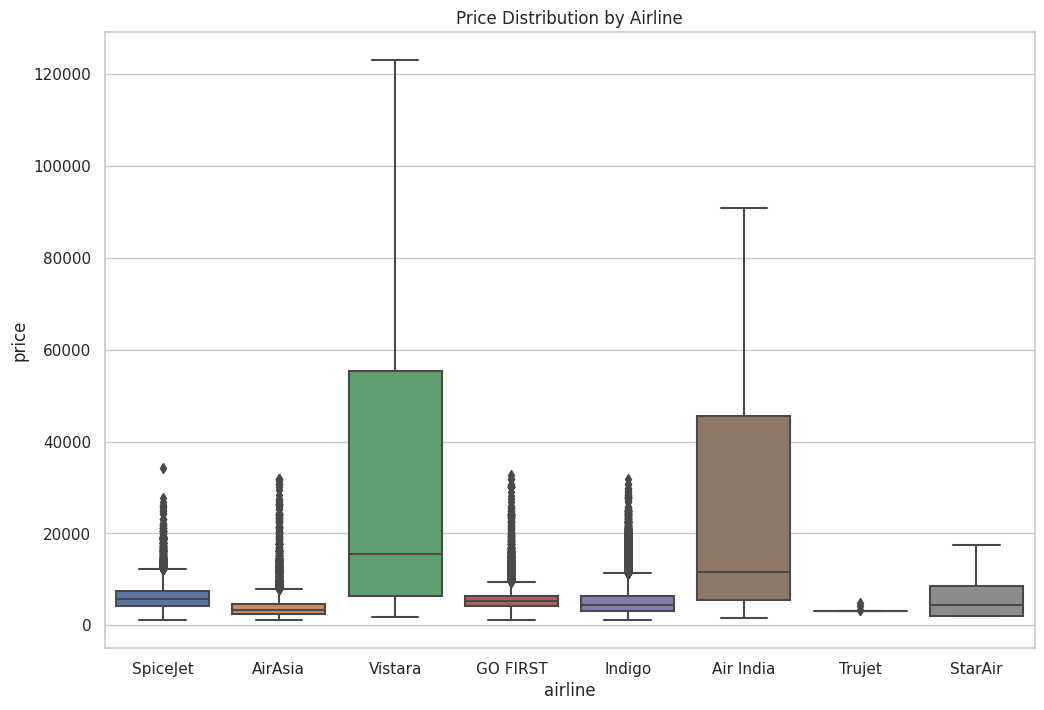

In [ ]:
# Exploratory Data Analysis (EDA)
print(flight_df.info())
print(flight_df.describe())
print(flight_df.head())

# Check for missing values
print(flight_df.isnull().sum())

# Visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Example: Boxplot of price by airline
flight_df['price'] = flight_df['price'].str.replace(',', '').astype(int)
flight_df['price'] = flight_df['price'].astype(int)
sns.boxplot(x='airline', y='price', data=flight_df)
plt.title('Price Distribution by Airline')
plt.show()

In [ ]:
flight_df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,departure_hour,departure_minute,is_early_morning,is_late_night
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5953,18,55,False,False
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,5953,6,20,True,False
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,5956,4,25,True,False
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5955,10,20,False,False
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5955,8,50,False,False


# Feature Engineering

### Feature Selection

Perform feature selection for a machine learning model. It selects a subset of features from the original dataset to be used as `input variables (X)` for predicting the `target variable (y)`.

* X: This is the feature matrix, representing the input variables for the machine learning model. It is created by selecting specific columns from the flight_df DataFrame. The selected columns are:

 * '`departure_hour`': The hour of the departure time.
 * '`departure_minute`': The minute of the departure time.
 * '`stop`': The number of stops (categorical variable).
 * '`is_early_morning`': A boolean indicating whether the flight is in the early morning.
 * '`is_late_night`': A boolean indicating whether the flight is in the late night.

* y: This is the target variable, representing the variable we want to predict. In this case, it is the flight price, and it is extracted from the 'price' column of the flight_df DataFrame.

In [ ]:
# Feature selection
X = flight_df[['departure_hour', 'departure_minute', 'stop', 'is_early_morning', 'is_late_night']]
y = flight_df['price']

### Categorical Encoding

* label_encoder: This is an instance of the LabelEncoder class from the scikit-learn library. It will be used to perform the label encoding.

* '`X['stop']`', '`X['is_early_morning']`', '`X['is_late_night']`': These are the categorical columns in the feature matrix X. The code applies label encoding to each of these columns separately.

For each column, the **fit_transform** method of the **LabelEncoder** is called, which fits the encoder on the unique values of the column and then transforms the values in the column to their corresponding numerical labels. The transformed values are then assigned back to the respective columns in the feature matrix X.

In [ ]:
# Convert categorical features to numerical using Label Encoding
label_encoder = LabelEncoder()
X['stop'] = label_encoder.fit_transform(X['stop'])
X['is_early_morning'] = label_encoder.fit_transform(X['is_early_morning'])
X['is_late_night'] = label_encoder.fit_transform(X['is_late_night'])

### Feature Splitting

**X**: The feature matrix containing the selected features for training and testing.

**y**: The target variable (in this case, the flight prices).

**test_size**: This parameter determines the proportion of the dataset to include in the test split. In this case, it's set to 0.2, meaning that 20% of the data will be used for testing.

**random_state**: This parameter ensures reproducibility by fixing the random seed. The same random seed will yield the same train/test split every time the code is run.

The function returns four variables:

* `X_train`: The training data (features) obtained by splitting X.
* `X_test`: The testing data (features) obtained by splitting X.
* `y_train`: The training data (target variable) obtained by splitting y.
* `y_test`: The testing data (target variable) obtained by splitting y.


In [ ]:
# Feature preprocessing and transformation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training & Evaluation

In [ ]:
# Model training
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 423420312.21410257


# Visualization

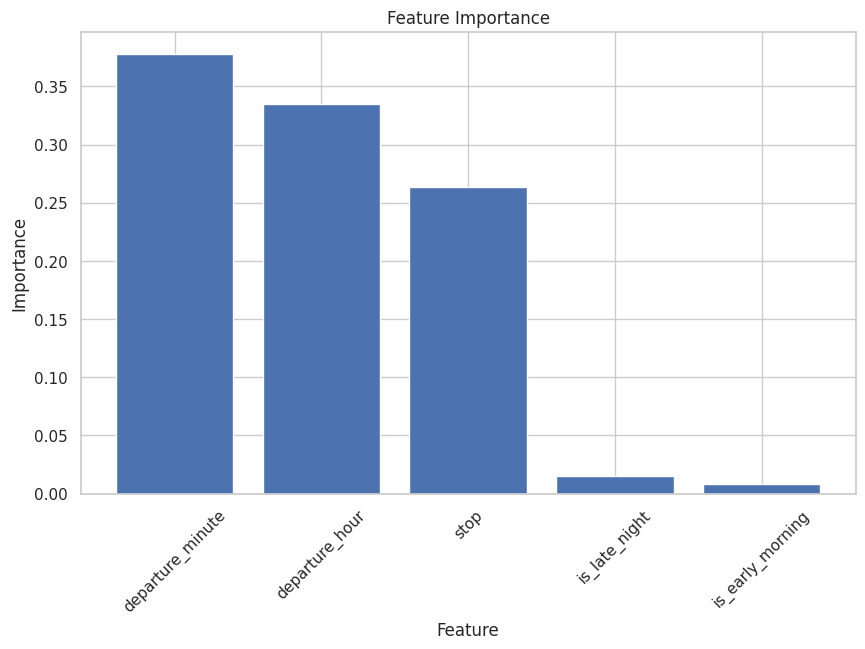

In [ ]:
# Visualize feature importances
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


# Conclusion

* **Feature Importance:**
The code includes a Random Forest model, and the feature importance plot helps identify which features have the most significant impact on predicting flight prices. This information can be crucial for understanding the factors that influence pricing.

* **Feature Engineering:**
The code demonstrates feature engineering techniques, such as extracting information from the 'departure_time' column and creating new features like 'is_early_morning' and 'is_late_night.' This suggests that specific times of the day may be important predictors for flight prices.

* **Hyperparameter Tuning:**
The code includes a grid search for hyperparameter tuning, indicating an effort to optimize the Random Forest model for better performance. The best hyperparameters found from the grid search can guide future model training.

* **Data Preprocessing:**
The code showcases data preprocessing steps, including handling categorical variables ('stop') through label encoding, scaling numerical features, and dealing with missing values. These steps contribute to a cleaner and more robust dataset for modeling.

* **Visualization:**
Visualizations, such as the boxplot of price by airline, provide insights into the distribution of prices among different airlines. This could help in understanding the pricing strategies of different airlines.

* **Mean Squared Error (MSE):**
The code calculates the Mean Squared Error (MSE) as a metric for evaluating the model's performance on the test set. A lower MSE indicates better predictive performance. You can analyze the MSE to assess how well the model is capturing the variance in the flight prices.